In [43]:
%load_ext autoreload
%autoreload 2

# System imports
import sys
import os
import multiprocessing as mp
from functools import partial
import yaml
import logging
import seaborn as sns

# 3rd party imports
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
import torch
from torch.nn import Linear
import torch.nn as nn
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import Data

sys.path.append("../../../LightningModules")

# Local imports
# from Processing.utils.event_utils import prepare_event

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup ITk Processing

## Top-level Class

In [3]:
class FeatureStore(LightningDataModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams

        self.input_dir = self.hparams["input_dir"]
        self.output_dir = self.hparams["output_dir"]
        self.n_files = self.hparams["n_files"]

        self.n_tasks = self.hparams["n_tasks"]
        self.task = 0 if "task" not in self.hparams else self.hparams["task"]
        self.n_workers = (
            self.hparams["n_workers"]
            if "n_workers" in self.hparams
            else len(os.sched_getaffinity(0))
        )
        self.build_weights = (
            self.hparams["build_weights"] if "build_weights" in self.hparams else True
        )
        self.show_progress = (
            self.hparams["show_progress"] if "show_progress" in self.hparams else True
        )

    def prepare_data(self):
        # Find the input files
        all_files = os.listdir(self.input_dir)
        all_events = sorted(
            np.unique([os.path.join(self.input_dir, event[:14]) for event in all_files])
        )[: self.n_files]

        # Split the input files by number of tasks and select my chunk only
        all_events = np.array_split(all_events, self.n_tasks)[self.task]

        # Define the cell features to be added to the dataset

        cell_features = [
            "norm_x",
            "norm_y",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
            "eta_angle_1",
            "phi_angle_1",
            "eta_angle_2",
            "phi_angle_2",
        ]

        # Prepare output
        # output_dir = os.path.expandvars(self.output_dir) FIGURE OUT HOW TO USE THIS!
        os.makedirs(self.output_dir, exist_ok=True)
        print("Writing outputs to " + self.output_dir)

        return prepare_event(all_events[0], cell_features=cell_features, **self.hparams)

        # Process input files with a worker pool and progress bar


#         process_func = partial(
#             prepare_event,
#             cell_features=cell_features,
#             **self.hparams
#         )
#         process_map(process_func, all_events, max_workers=self.n_workers)

## Utils

### Event Prep Top Level

In [5]:
def prepare_event(
    event_file,
    cell_features,
    progressbar=None,
    output_dir=None,
    pt_min=0,
    endcaps=False,
    modulewise=True,
    layerwise=False,
    noise=False,
    cell_information=True,
    overwrite=False,
    **kwargs
):

    try:
        evtid = int(event_file[-9:])
        filename = os.path.join(output_dir, str(evtid))

        if not os.path.exists(filename) or overwrite:
            logging.info("Preparing event {}".format(evtid))
            feature_scale = [1000, np.pi, 1000]

            (
                X,
                cell_data,
                pid,
                modulewise_true_edges,
                layerwise_true_edges,
                hid,
                pt,
                primary,
                nhits,
            ) = build_event(
                event_file,
                pt_min,
                feature_scale,
                cell_features,
                cell_information=cell_information,
                endcaps=endcaps,
                modulewise=modulewise,
                layerwise=layerwise,
                noise=noise,
            )

            hit_data = Data(
                x=torch.from_numpy(X).float(),
                cell_data=torch.from_numpy(cell_data).float(),
                pid=torch.from_numpy(pid),
                event_file=event_file,
                hid=torch.from_numpy(hid),
                pt=torch.from_numpy(pt),
                primary=torch.from_numpy(primary),
                nhits=torch.from_numpy(nhits),
            )
            if modulewise_true_edges is not None:
                hit_data.modulewise_true_edges = torch.from_numpy(modulewise_true_edges)
            if layerwise_true_edges is not None:
                hit_data.layerwise_true_edges = torch.from_numpy(layerwise_true_edges)

            #             with open(filename, "wb") as pickle_file:
            #                 torch.save(hit_data, pickle_file)

            return hit_data

        else:
            logging.info("{} already exists".format(evtid))
    except Exception as inst:
        print("Exception with file:", event_file, "Exception:", inst)

### Cell Info

In [6]:
def get_cell_information(hits, cell_features):
    cell_data = hits[cell_features]
    pixel_bool = (hits["hardware"] == "PIXEL").astype(int)

    cell_data = cell_data.assign(pixel=pixel_bool)

    return cell_data

### Build Hits

In [7]:
def get_layerwise_edges(hits):

    hits = hits.assign(
        R=np.sqrt(
            (hits.x - hits.vx) ** 2 + (hits.y - hits.vy) ** 2 + (hits.z - hits.vz) ** 2
        )
    )
    hits = hits.sort_values("R").reset_index(drop=True).reset_index(drop=False)
    hits.particle_id[hits.particle_id == 0] = np.nan
    hit_list = (
        hits.groupby(["particle_id", "layer"], sort=False)["index"]
        .agg(lambda x: list(x))
        .groupby(level=0)
        .agg(lambda x: list(x))
    )

    true_edges = []
    for row in hit_list.values:
        for i, j in zip(row[0:-1], row[1:]):
            true_edges.extend(list(itertools.product(i, j)))
    true_edges = np.array(true_edges).T

    return true_edges, hits


def get_modulewise_edges(hits):

    signal = hits[
        ((~hits.particle_id.isna()) & (hits.particle_id != 0)) & (~hits.vx.isna())
    ]
    signal = signal.drop_duplicates(
        subset=[
            "particle_id",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
        ]
    )

    # Sort by increasing distance from production
    signal = signal.assign(
        R=np.sqrt(
            (signal.x - signal.vx) ** 2
            + (signal.y - signal.vy) ** 2
            + (signal.z - signal.vz) ** 2
        )
    )
    signal = signal.sort_values("R").reset_index(drop=False)

    # Handle re-indexing
    signal = signal.rename(columns={"index": "unsorted_index"}).reset_index(drop=False)
    signal.loc[signal["particle_id"] == 0, "particle_id"] = np.nan

    # Group by particle ID
    signal_list = signal.groupby(["particle_id"], sort=False)["index"].agg(
        lambda x: list(x)
    )

    true_edges = []
    for row in signal_list.values:
        for i, j in zip(row[:-1], row[1:]):
            true_edges.append([i, j])

    true_edges = np.array(true_edges).T

    true_edges = signal.unsorted_index.values[true_edges]

    return true_edges

In [12]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))


def select_hits(hits, particles, pt_min=0, endcaps=True, noise=True):

    particles = particles[(particles.pt > pt_min)]
    particles = particles.assign(primary=(particles.barcode < 200000).astype(int))

    if not endcaps:
        hits = hits[hits["barrel_endcap"] == 0]

    if noise:
        hits = hits.merge(
            particles[["particle_id", "pt", "vx", "vy", "vz", "primary"]],
            on="particle_id",
            how="left",
        )
    else:
        hits = hits.merge(
            particles[["particle_id", "pt", "vx", "vy", "vz", "primary"]],
            on="particle_id",
        )

    hits["nhits"] = hits.groupby("particle_id")["particle_id"].transform("count")
    hits.loc[hits.particle_id == 0, "nhits"] = -1

    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    eta = calc_eta(r, hits.z)
    # Select the data columns we need
    hits = hits.assign(r=r, phi=phi, eta=eta)

    return hits


def build_event(
    event_file,
    pt_min,
    feature_scale,
    cell_features,
    cell_information=True,
    endcaps=False,
    modulewise=True,
    layerwise=False,
    noise=False,
):
    # Get true edge list using the ordering by R' = distance from production vertex of each particle
    particles = pd.read_csv(event_file + "-particles.csv")
    hits = pd.read_csv(event_file + "-truth.csv")

    hits = select_hits(
        hits, particles, pt_min=pt_min, endcaps=endcaps, noise=noise
    ).assign(evtid=int(event_file[-9:]))

    # Handle which truth graph(s) are being produced
    modulewise_true_edges, layerwise_true_edges = None, None

    if modulewise:
        modulewise_true_edges = get_modulewise_edges(hits)
        logging.info(
            "Layerless truth graph built for {} with size {}".format(
                event_file, modulewise_true_edges.shape
            )
        )

    if layerwise:
        layerwise_true_edges, hits = get_layerwise_edges(hits)
        logging.info(
            "Layerwise truth graph built for {} with size {}".format(
                event_file, layerwise_true_edges.shape
            )
        )

    if cell_information:
        logging.info("Getting cell info")
        cell_data = get_cell_information(hits, cell_features)

    logging.info("Weights constructed")

    return (
        hits[["r", "phi", "z"]].to_numpy() / feature_scale,
        cell_data.to_numpy(),
        hits.particle_id.to_numpy(),
        modulewise_true_edges,
        layerwise_true_edges,
        hits["hit_id"].to_numpy(),
        hits.pt.to_numpy(),
        hits.primary.to_numpy(),
        hits.nhits.to_numpy(),
    )

# Run Processing

In [30]:
store = FeatureStore(config)

In [31]:
outputs = store.prepare_data()

Writing outputs to /project/projectdirs/m3443/data/ITk-upgrade/processed/feature_store_modulewise
Hits:         hit_id         x          y        z  cluster_index_1  \
0            0  -34.0491  -20.60520  -263.00                0   
1            1  -40.1447  -13.68350  -263.00                1   
2            2  -48.7276  -10.86440  -263.00                2   
3            3  -37.7332   -3.92741  -263.00                3   
4            4  -44.8554  -22.53920  -263.00                4   
...        ...       ...        ...      ...              ...   
341977  340463  909.7290 -113.10100  2854.25           475402   
341978  340464  915.8000 -129.20300  2854.25           475404   
341979  340465  896.5540 -141.31400  2854.25           475405   
341980  340466  951.8640 -162.12100  2854.25           475406   
341981  340467  893.0680 -161.89200  2854.25           475407   

        cluster_index_2  particle_id hardware  cluster_x_1  cluster_y_1  ...  \
0                    -1  6908000055

## Manual Running

In [3]:
config_file = "../../../LightningModules/Processing/configs/itk_feature_store.yaml"
with open(config_file, "r") as stream:
    config = yaml.safe_load(stream)

In [4]:
config

{'input_dir': '${ITK_DATA}/uncorrelated_events',
 'output_dir': '${ITK_DATA}/feature_store/feature_store_uncorrelated',
 'n_files': 300,
 'n_workers': 32,
 'n_tasks': 1,
 'overwrite': True,
 'endcaps': True,
 'noise': True,
 'modulewise': True,
 'layerwise': False,
 'cell_information': True}

In [5]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/uncorrelated_events"
all_files = os.listdir(input_dir)
all_events = sorted(
    np.unique([os.path.join(input_dir, event[:14]) for event in all_files])
)[: config["n_files"]]

In [6]:
event_file = all_events[0]

In [7]:
event_file

'/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/uncorrelated_events/event000000001'

## Module Debugging

In [7]:
layer_disk_min, layer_disk_max, eta_module_min, eta_module_max, phi_module_min, phi_module_max = [[]]*6
for event_file in all_events:
    print(event_file)
    hits = pd.read_csv(event_file + "-truth.csv")
    layer_disk_min, layer_disk_max = hits.layer_disk.min(), hits.layer_disk.max()
    eta_module_min, eta_module_max = hits.eta_module.min(), hits.eta_module.max()
    phi_module_min, phi_module_max = hits.phi_module.min(), hits.phi_module.max()

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010002
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010003
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010004
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010005
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010006
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010007
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010008
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010009
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010010
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010011
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010012
/global/cfs/cdirs/m3443/data

KeyboardInterrupt: 

In [9]:
np.min(layer_disk_min), np.max(layer_disk_max), np.min(eta_module_min), np.max(eta_module_max), np.min(phi_module_min), np.max(phi_module_max)

(0, 5, -18, 29, 0, 71)

In [18]:
layer_disk_set = np.arange(np.min(layer_disk_min), np.max(layer_disk_max)+1)

In [19]:
eta_module_set = np.arange(np.min(eta_module_min), np.max(eta_module_max)+1)

In [20]:
phi_module_set = np.arange(np.min(phi_module_min), np.max(phi_module_max)+1)

In [21]:
barrel_endcap_set = np.array([-2, 0, 2])

In [22]:
hardware_set = np.array(["PIXEL", "STRIP"])

In [23]:
import itertools

In [39]:
hits.columns

Index(['hit_id', 'x', 'y', 'z', 'cluster_index_1', 'cluster_index_2',
       'particle_id', 'hardware', 'cluster_x_1', 'cluster_y_1', 'cluster_z_1',
       'barrel_endcap', 'layer_disk', 'eta_module', 'phi_module',
       'eta_angle_1', 'phi_angle_1', 'norm_x', 'norm_y', 'norm_z_1',
       'cluster_x_2', 'cluster_y_2', 'cluster_z_2', 'eta_angle_2',
       'phi_angle_2', 'norm_z_2'],
      dtype='object')

In [44]:
module_dict = pd.DataFrame(np.array(list(itertools.product(hardware_set, layer_disk_set, eta_module_set, phi_module_set, barrel_endcap_set))), 
            columns=["hardware", "layer_disk", "eta_module", "phi_module", "barrel_endcap"]).reset_index().rename(columns={"index": "module_index"})

In [60]:
module_dict.to_pickle(os.path.join(os.path.split(os.path.split(all_events[0])[0])[0], "module_lookup"))

In [47]:
pd.read_pickle("module_dict")

,module_index,hardware,layer_disk,eta_module,phi_module,barrel_endcap
0,0,PIXEL,0,-18,0,-2
1,1,PIXEL,0,-18,0,0
2,2,PIXEL,0,-18,0,2
3,3,PIXEL,0,-18,1,-2
4,4,PIXEL,0,-18,1,0
...,...,...,...,...,...,...
124411,124411,STRIP,5,29,70,0
124412,124412,STRIP,5,29,70,2
124413,124413,STRIP,5,29,71,-2
124414,124414,STRIP,5,29,71,0


In [58]:
module_dict = module_dict.astype({"hardware": str, "layer_disk": int, "eta_module": int, "phi_module": int, "barrel_endcap": int})

In [59]:
hits.merge(module_dict, on=["hardware", "layer_disk", "eta_module", "phi_module", "barrel_endcap"], how="left")

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2,module_index
0,0,-47.4613,-23.17560,-263.00,0,-1,0,PIXEL,-47.4613,-23.17560,...,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0,3888
1,1,-44.3762,-9.41112,-263.00,1,-1,52950000365,PIXEL,-44.3762,-9.41112,...,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0,3888
2,2,-35.3306,-19.65470,-263.00,2,-1,52920000573,PIXEL,-35.3306,-19.65470,...,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0,3888
3,3,-33.6953,-18.78170,-263.00,3,-1,52950200001,PIXEL,-33.6953,-18.78170,...,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0,3888
4,4,-39.2989,-5.01444,-263.00,4,-1,52710000112,PIXEL,-39.2989,-5.01444,...,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0,3888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288019,286821,868.3000,-92.44040,2854.25,406174,406184,0,STRIP,882.5250,-94.24840,...,0.0,0.0,1.0,882.584,-93.6911,2860.75,0.044197,0.006416,-1.0,119207
288020,286822,900.8160,-110.94700,2854.25,406177,406191,0,STRIP,930.5990,-115.21900,...,0.0,0.0,1.0,930.775,-113.7870,2860.75,1.324640,0.006379,-1.0,119207
288021,286823,957.1440,-127.15600,2854.25,406178,406190,53880200015,STRIP,929.6030,-122.99300,...,0.0,0.0,1.0,929.357,-124.8390,2860.75,1.115850,0.006379,-1.0,119207
288022,286824,931.0580,-137.46900,2854.25,406179,406189,0,STRIP,927.6580,-136.89000,...,0.0,0.0,1.0,927.633,-137.0640,2860.75,1.324640,0.006379,-1.0,119207


In [54]:
module_dict

,module_index,hardware,layer_disk,eta_module,phi_module,barrel_endcap
0,0,PIXEL,0,-18,0,-2
1,1,PIXEL,0,-18,0,0
2,2,PIXEL,0,-18,0,2
3,3,PIXEL,0,-18,1,-2
4,4,PIXEL,0,-18,1,0
...,...,...,...,...,...,...
124411,124411,STRIP,5,29,70,0
124412,124412,STRIP,5,29,70,2
124413,124413,STRIP,5,29,71,-2
124414,124414,STRIP,5,29,71,0


In [52]:
os.path.join(os.path.split(os.path.split(all_events[0])[0])[0], "module_lookup")

'/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/module_dict'

In [11]:
particles = pd.read_csv(event_file + "-particles.csv")
hits = pd.read_csv(event_file + "-truth.csv")

In [16]:
hits

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-47.4613,-23.17560,-263.00,0,-1,0,PIXEL,-47.4613,-23.17560,...,0.982794,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0
1,1,-44.3762,-9.41112,-263.00,1,-1,52950000365,PIXEL,-44.3762,-9.41112,...,0.785398,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0
2,2,-35.3306,-19.65470,-263.00,2,-1,52920000573,PIXEL,-35.3306,-19.65470,...,1.249050,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0
3,3,-33.6953,-18.78170,-263.00,3,-1,52950200001,PIXEL,-33.6953,-18.78170,...,0.982794,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0
4,4,-39.2989,-5.01444,-263.00,4,-1,52710000112,PIXEL,-39.2989,-5.01444,...,1.249050,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.000000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288019,286821,868.3000,-92.44040,2854.25,406174,406184,0,STRIP,882.5250,-94.24840,...,0.006379,0.0,0.0,1.0,882.584,-93.6911,2860.75,0.044197,0.006416,-1.0
288020,286822,900.8160,-110.94700,2854.25,406177,406191,0,STRIP,930.5990,-115.21900,...,0.006379,0.0,0.0,1.0,930.775,-113.7870,2860.75,1.324640,0.006379,-1.0
288021,286823,957.1440,-127.15600,2854.25,406178,406190,53880200015,STRIP,929.6030,-122.99300,...,0.006379,0.0,0.0,1.0,929.357,-124.8390,2860.75,1.115850,0.006379,-1.0
288022,286824,931.0580,-137.46900,2854.25,406179,406189,0,STRIP,927.6580,-136.89000,...,0.006379,0.0,0.0,1.0,927.633,-137.0640,2860.75,1.324640,0.006379,-1.0


In [12]:
hits = hits[["barrel_endcap", "layer_disk", "eta_module", "phi_module", "hit_id", "hardware"]]

In [14]:
hits.phi_module.max()

71

In [17]:
hits.groupby(["barrel_endcap", "layer_disk", "eta_module", "phi_module"]).count()

hit_id  hardware
barrel_endcap layer_disk eta_module phi_module                  
-2            0          0          0               73        73
                                    1               50        50
                                    2               52        52
                                    3               54        54
                                    4               62        62
...                                                ...       ...
 2            5          5          59              10        10
                                    60              10        10
                                    61               5         5
                                    62               6         6
                                    63               5         5

[13499 rows x 2 columns]

In [39]:
hits[(hits["barrel_endcap"] == 0) & (hits["layer_disk"] == 0) & (hits["eta_module"] == -12) & (hits["phi_module"] == 0)]

,barrel_endcap,layer_disk,eta_module,phi_module,hit_id,hardware
80617,0,0,-12,0,80383,PIXEL
80618,0,0,-12,0,80384,PIXEL
80619,0,0,-12,0,80385,PIXEL
80620,0,0,-12,0,80386,PIXEL
80621,0,0,-12,0,80387,PIXEL
80622,0,0,-12,0,80388,PIXEL
80623,0,0,-12,0,80389,PIXEL
80624,0,0,-12,0,80390,PIXEL
80625,0,0,-12,0,80391,PIXEL
80626,0,0,-12,0,80392,PIXEL


In [44]:
hits["layer_disk"].min(), hits["eta_module"].min(), hits["phi_module"].min()

(0, -18, 0)

In [43]:
hits["layer_disk"].max(), hits["eta_module"].max(), hits["phi_module"].max()

(5, 29, 71)

In [19]:
sample = torch.load("/global/cfs/cdirs/m3443/data/trackml-codalab/feature_store/all_data_moduletest/21000")

In [22]:
sample

Data(x=[125576, 3], pid=[125576], modules=[125576], event_file='/global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021000', hid=[125576], pt=[125576], weights=[96834], modulewise_true_edges=[2, 96834], cell_data=[125576, 9])

In [24]:
sample.modules.unique()

tensor([    0,     1,     2,  ..., 18725, 18726, 18727])

In [41]:
r, phi, z = sample.x.T
x, y = r * np.cos(phi * np.pi) * 1000, r * np.sin(phi * np.pi) * 1000
z = z * 1000

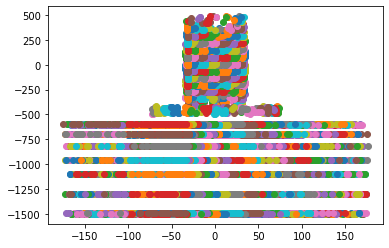

In [53]:
for mod in sample.modules.unique()[:1000]:
    mod_x = x[sample.modules == mod]
    mod_y = y[sample.modules == mod]
    mod_z = z[sample.modules == mod]
    plt.scatter(mod_x, mod_z)

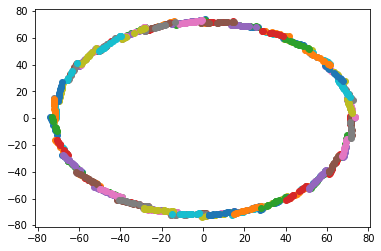

In [54]:
for mod in sample.modules.unique()[1000:1100]:
    mod_x = x[sample.modules == mod]
    mod_y = y[sample.modules == mod]
    mod_z = z[sample.modules == mod]
    plt.scatter(mod_x, mod_y)

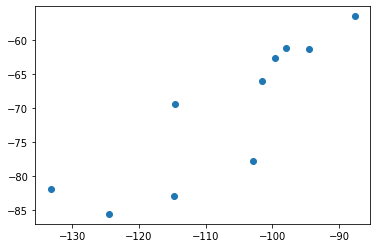

In [49]:
mod = 10
mod_x = x[sample.modules == mod]
mod_y = y[sample.modules == mod]
mod_z = z[sample.modules == mod]
plt.scatter(mod_x, mod_y)

## Duplicate Debugging

In [16]:
input_dir = config["input_dir"]
all_files = os.listdir(input_dir)
selected_event = sorted(
    np.unique([os.path.join(input_dir, event[:14]) for event in all_files])
)[0]

In [17]:
particles = pd.read_csv(selected_event + "-particles.csv")
hits = pd.read_csv(selected_event + "-truth.csv")

In [19]:
particles.groupby("particle_id")["particle_id"].transform("count")

0        1
1        1
2        1
3        1
4        1
        ..
97498    1
97499    1
97500    1
97501    1
97502    1
Name: particle_id, Length: 97503, dtype: int64

In [100]:
noise = hits[hits.particle_id == 0]

In [103]:
noise.shape

(187880, 26)

In [104]:
noise.drop_duplicates(
    subset=["particle_id", "barrel_endcap", "layer_disk", "eta_module", "phi_module"]
)

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
1,1,-40.1447,-13.68350,-263.00,1,-1,0,PIXEL,-40.1447,-13.68350,...,0.982794,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.00000,-1.000000,-1.0
54,54,-49.0626,-24.09900,-286.00,54,-1,0,PIXEL,-49.0626,-24.09900,...,0.982794,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.00000,-1.000000,-1.0
109,108,-40.0831,-16.67760,-315.00,108,-1,0,PIXEL,-40.0831,-16.67760,...,1.249050,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.00000,-1.000000,-1.0
168,167,-51.9474,-18.42960,-346.00,167,-1,0,PIXEL,-51.9474,-18.42960,...,0.982794,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.00000,-1.000000,-1.0
209,208,-41.5472,-6.22219,-383.00,208,-1,0,PIXEL,-41.5472,-6.22219,...,0.463648,0.0,0.0,-1.0,-1.000,-1.0000,-1.00,-1.00000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341937,340423,793.0130,-163.08000,2854.25,475300,475315,0,STRIP,768.2150,-157.49000,...,0.005862,0.0,0.0,1.0,767.844,-159.2890,2860.75,1.11695,0.005863,-1.0
341945,340431,874.1650,-244.16200,2854.25,475324,475336,0,STRIP,854.9360,-238.35900,...,0.006379,0.0,0.0,1.0,903.148,-252.2140,2860.75,1.32464,0.006379,-1.0
341950,340436,661.2720,-103.33700,2854.25,475338,475364,0,STRIP,646.9180,-100.78000,...,0.010950,0.0,0.0,1.0,646.774,-101.6990,2860.75,1.33240,0.010950,-1.0
341964,340450,803.5610,-98.73020,2854.25,475378,475390,0,STRIP,778.3970,-95.15420,...,0.005863,0.0,0.0,1.0,778.165,-97.0371,2860.75,1.32385,0.005863,-1.0


In [106]:
signal = hits[hits.particle_id != 0]

In [108]:
signal.shape

(154102, 26)

In [109]:
signal.drop_duplicates(
    subset=["particle_id", "barrel_endcap", "layer_disk", "eta_module", "phi_module"]
)

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-34.0491,-20.60520,-263.00,0,-1,69080000558,PIXEL,-34.0491,-20.60520,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
2,2,-48.7276,-10.86440,-263.00,2,-1,69700000868,PIXEL,-48.7276,-10.86440,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
3,3,-37.7332,-3.92741,-263.00,3,-1,68480000239,PIXEL,-37.7332,-3.92741,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
4,4,-44.8554,-22.53920,-263.00,4,-1,69800000521,PIXEL,-44.8554,-22.53920,...,1.249050,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
5,5,-35.2181,-17.33120,-263.00,5,-1,68930000513,PIXEL,-35.2181,-17.33120,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341974,340460,899.0960,-107.95500,2854.25,475397,475417,68130200183,STRIP,881.2530,-105.47300,...,0.006379,0.0,0.0,1.0,881.137,-106.445,2860.75,1.11586,0.006380,-1.0
341975,340461,882.4100,-142.76200,2854.25,475399,475416,68610200072,STRIP,876.1720,-141.61100,...,0.006379,0.0,0.0,1.0,876.124,-141.910,2860.75,1.32464,0.006379,-1.0
341977,340463,909.7290,-113.10100,2854.25,475402,475425,68310200423,STRIP,930.4900,-116.09600,...,0.006379,0.0,0.0,1.0,930.588,-115.304,2860.75,1.32464,0.006379,-1.0
341978,340464,915.8000,-129.20300,2854.25,475404,475423,68940200217,STRIP,928.4750,-131.23900,...,0.006379,0.0,0.0,1.0,928.535,-130.815,2860.75,1.11586,0.006379,-1.0


In [105]:
hits

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-34.0491,-20.60520,-263.00,0,-1,69080000558,PIXEL,-34.0491,-20.60520,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
1,1,-40.1447,-13.68350,-263.00,1,-1,0,PIXEL,-40.1447,-13.68350,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
2,2,-48.7276,-10.86440,-263.00,2,-1,69700000868,PIXEL,-48.7276,-10.86440,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
3,3,-37.7332,-3.92741,-263.00,3,-1,68480000239,PIXEL,-37.7332,-3.92741,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
4,4,-44.8554,-22.53920,-263.00,4,-1,69800000521,PIXEL,-44.8554,-22.53920,...,1.249050,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341977,340463,909.7290,-113.10100,2854.25,475402,475425,68310200423,STRIP,930.4900,-116.09600,...,0.006379,0.0,0.0,1.0,930.588,-115.304,2860.75,1.32464,0.006379,-1.0
341978,340464,915.8000,-129.20300,2854.25,475404,475423,68940200217,STRIP,928.4750,-131.23900,...,0.006379,0.0,0.0,1.0,928.535,-130.815,2860.75,1.11586,0.006379,-1.0
341979,340465,896.5540,-141.31400,2854.25,475405,475422,69100000796,STRIP,926.1750,-146.58900,...,0.006379,0.0,0.0,1.0,926.361,-145.411,2860.75,1.32464,0.006379,-1.0
341980,340466,951.8640,-162.12100,2854.25,475406,475421,0,STRIP,924.4820,-156.91000,...,0.006379,0.0,0.0,1.0,924.238,-158.342,2860.75,1.32464,0.006379,-1.0


## Modulewise vs Layerwise

In [75]:
from itertools import product

In [99]:
layers = list(
    product(
        outputs[0]["barrel_endcap"].unique(),
        outputs[0]["layer_disk"].unique(),
        outputs[0]["eta_module"].unique(),
    )
)

CPU times: user 9.92 s, sys: 3.43 s, total: 13.4 s
Wall time: 7.44 s


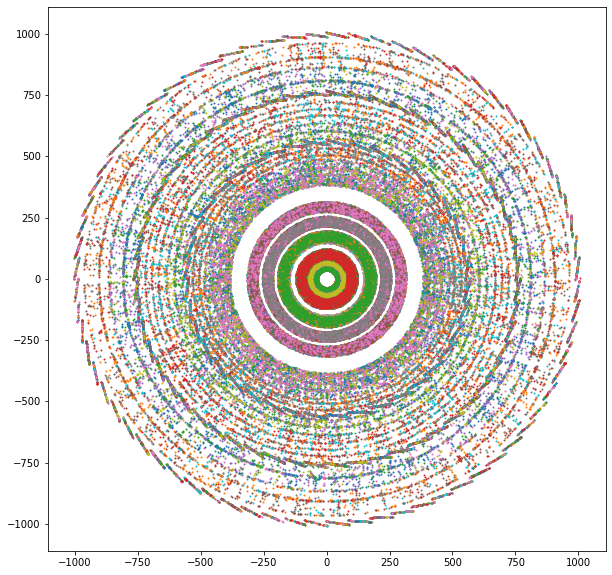

In [102]:
%%time
plt.figure(figsize=(10, 10))
for layer in layers:
    layer_hits = hits[
        (hits[["barrel_endcap", "layer_disk", "eta_module"]] == layer).all(1)
    ]
    plt.scatter(layer_hits.x, layer_hits.y, s=1)

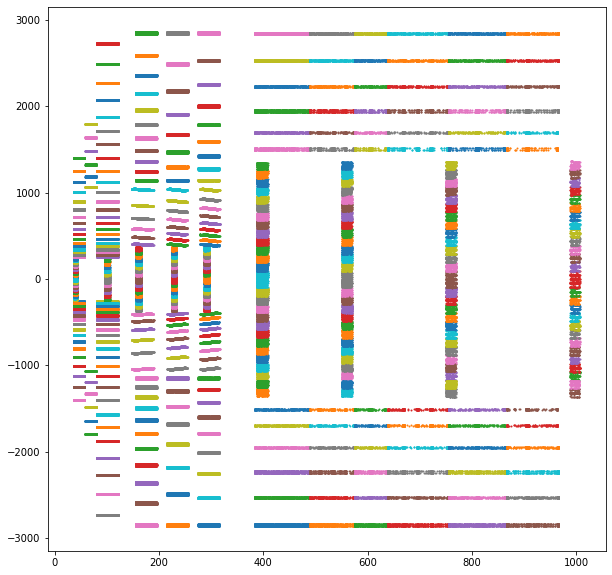

In [103]:
plt.figure(figsize=(10, 10))
for layer in layers:
    layer_hits = hits[
        (hits[["barrel_endcap", "layer_disk", "eta_module"]] == layer).all(1)
    ]
    plt.scatter(layer_hits.r, layer_hits.z, s=1)

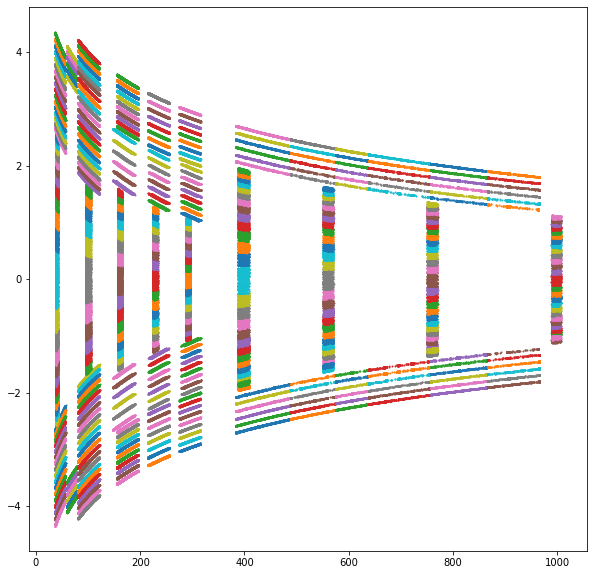

In [104]:
plt.figure(figsize=(10, 10))
for layer in layers:
    layer_hits = hits[
        (hits[["barrel_endcap", "layer_disk", "eta_module"]] == layer).all(1)
    ]
    plt.scatter(layer_hits.r, layer_hits.eta, s=1)

In [106]:
layers = list(
    product(outputs[0]["barrel_endcap"].unique(), outputs[0]["layer_disk"].unique())
)

CPU times: user 1.41 s, sys: 549 ms, total: 1.96 s
Wall time: 1.01 s


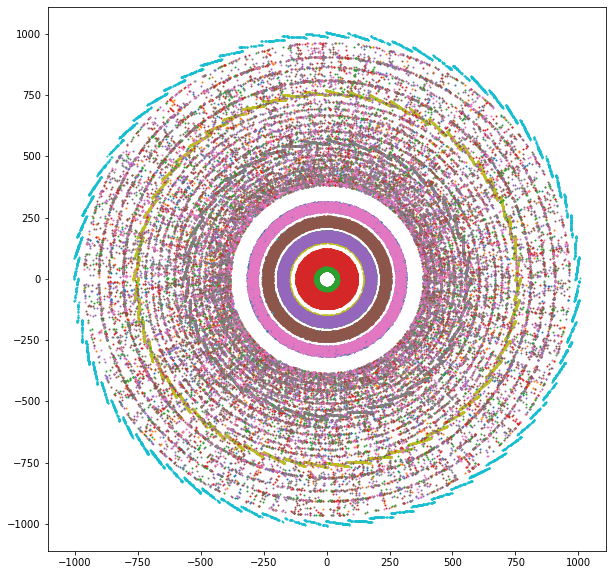

In [109]:
%%time
plt.figure(figsize=(10, 10))
for layer in layers:
    layer_hits = hits[(hits[["barrel_endcap", "layer_disk"]] == layer).all(1)]
    plt.scatter(layer_hits.x, layer_hits.y, s=1)

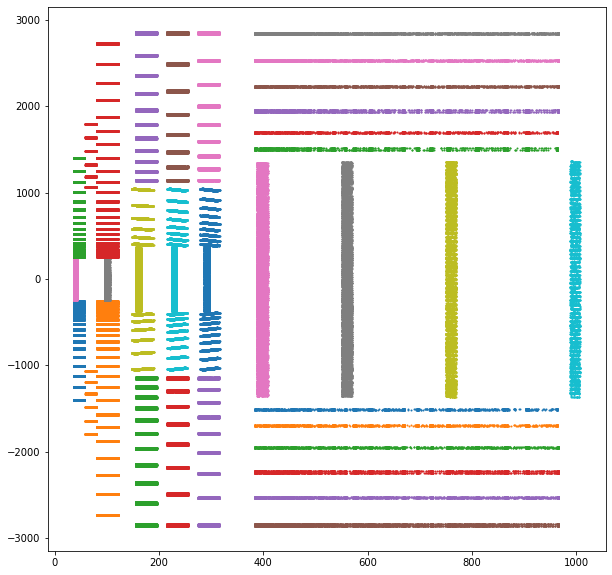

In [107]:
plt.figure(figsize=(10, 10))
for layer in layers:
    layer_hits = hits[(hits[["barrel_endcap", "layer_disk"]] == layer).all(1)]
    plt.scatter(layer_hits.r, layer_hits.z, s=1)

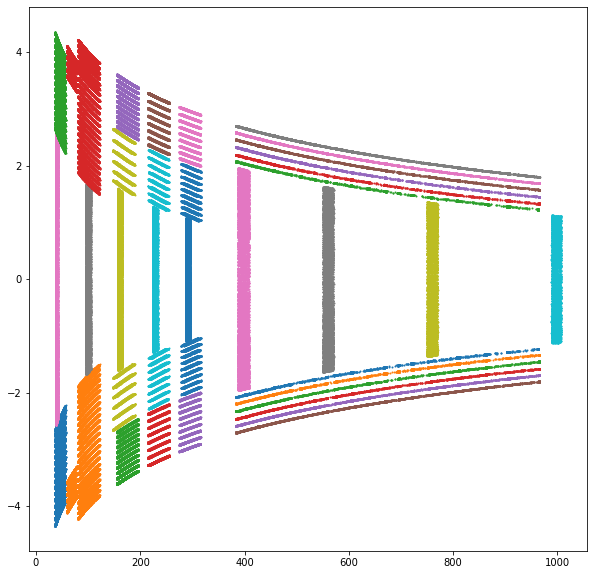

In [108]:
plt.figure(figsize=(10, 10))
for layer in layers:
    layer_hits = hits[(hits[["barrel_endcap", "layer_disk"]] == layer).all(1)]
    plt.scatter(layer_hits.r, layer_hits.eta, s=1)

## Particle pT Distribution

In [36]:
# Load event file -particles.csv and -truth.csv
particles = pd.read_csv(event_file + "-particles.csv")
hits = pd.read_csv(event_file + "-truth.csv")

In [38]:
hits = select_hits(hits, particles, pt_min=0, endcaps=True, noise=True)

In [33]:
signal_hits = hits[(hits.primary == 1.0) & (hits.nhits >= 3)]

In [40]:
particles = particles[particles.particle_id.isin(signal_hits.particle_id)]

In [50]:
poi = particles[particles.pt > 1000]
poi.pt = poi.pt / 1000

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:xlabel='pt', ylabel='Count'>

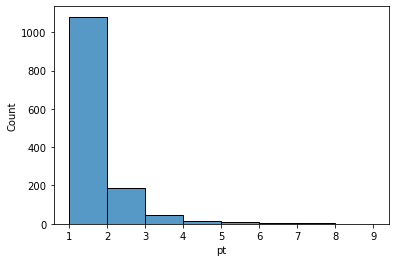

In [56]:
# Plot hist of poi pt from 1 to 2
sns.histplot(poi.pt, bins=np.arange(1, 10, 1))

  0%|          | 0/300 [00:00<?, ?it/s]/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 300/300 [04:41<00:00,  1.06it/s]


<AxesSubplot:xlabel='pt', ylabel='Count'>

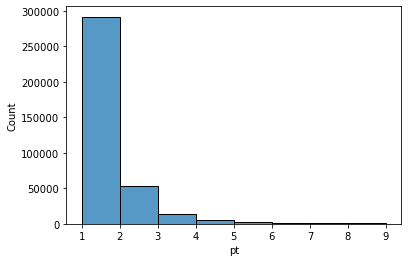

In [109]:
# Loop over event files, apply cuts, and plot hist of poi pt from 1 to 2
all_poi = []

# Shuffle all_events
all_events = np.random.permutation(all_events)

for event_file in tqdm(all_events[:1000]):
    # Load event file -particles.csv and -truth.csv
    particles = pd.read_csv(event_file + "-particles.csv")
    hits = pd.read_csv(event_file + "-truth.csv")

    # Apply cuts
    hits = select_hits(
        hits, particles, pt_min=0, endcaps=True, noise=True
    )
    signal_hits = hits[(hits.primary == 1.0) & (hits.nhits >= 3)]
    particles = particles[particles.particle_id.isin(signal_hits.particle_id)]

    # Plot hist of poi pt from 1 to 2
    poi = particles[particles.pt > 1000]
    poi.pt = poi.pt / 1000
    all_poi.append(poi)

all_poi_df = pd.concat(all_poi)
sns.histplot(all_poi_df.pt, bins=np.arange(1, 10, 1))

In [128]:
# Loop over all_poi and get mean, std of each pt hist bin
poi_hists = [ np.histogram(poi_df.pt, bins=np.arange(4, 12, 1))[0] for poi_df in all_poi ]
hist_mean, hist_std = np.stack(poi_hists).mean(0), np.stack(poi_hists).std(0)

high_eta_poi_hists = [
    np.histogram(poi_df[poi_df.eta.abs() > 2].pt, bins=np.arange(4, 12, 1))[0]
    for poi_df in all_poi
]
high_eta_hist_mean, high_eta_hist_std = np.stack(high_eta_poi_hists).mean(0), np.stack(high_eta_poi_hists).std(0)

low_eta_poi_hists = [
    np.histogram(poi_df[poi_df.eta.abs() < 2].pt, bins=np.arange(4, 12, 1))[0]
    for poi_df in all_poi
]
low_eta_hist_mean, low_eta_hist_std = np.stack(low_eta_poi_hists).mean(0), np.stack(low_eta_poi_hists).std(0)


Text(0, 0.5, 'Particle count within each event')

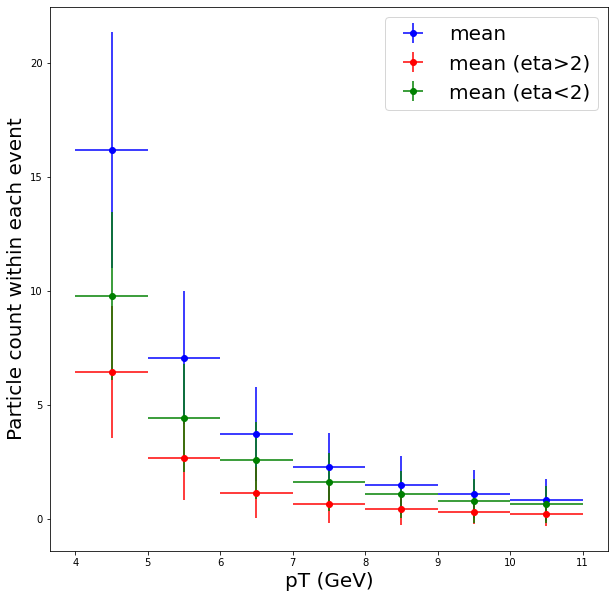

In [133]:
# Plot hist_mean and hist_std with error bars
plt.figure(figsize=(10, 10))
plt.errorbar(
    np.arange(4.5, 11.5, 1),
    hist_mean,
    yerr=hist_std,
    xerr=0.5,
    fmt="o",
    label="mean",
    color="blue",
)
plt.errorbar(
    np.arange(4.5, 11.5, 1),
    high_eta_hist_mean,
    yerr=high_eta_hist_std,
    xerr=0.5,
    fmt="o",
    label="mean (eta>2)",
    color="red",
)
plt.errorbar(
    np.arange(4.5, 11.5, 1),
    low_eta_hist_mean,
    yerr=low_eta_hist_std,
    xerr=0.5,
    fmt="o",
    label="mean (eta<2)",
    color="green",
)
plt.legend(fontsize=20)
plt.xlabel("pT (GeV)", fontsize=20)
plt.ylabel("Particle count within each event", fontsize=20)

<AxesSubplot:xlabel='pt', ylabel='Count'>

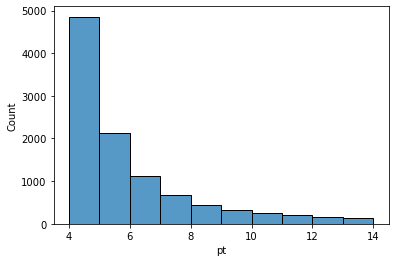

In [116]:
sns.histplot(all_poi_df.pt, bins=np.arange(4, 15, 1))

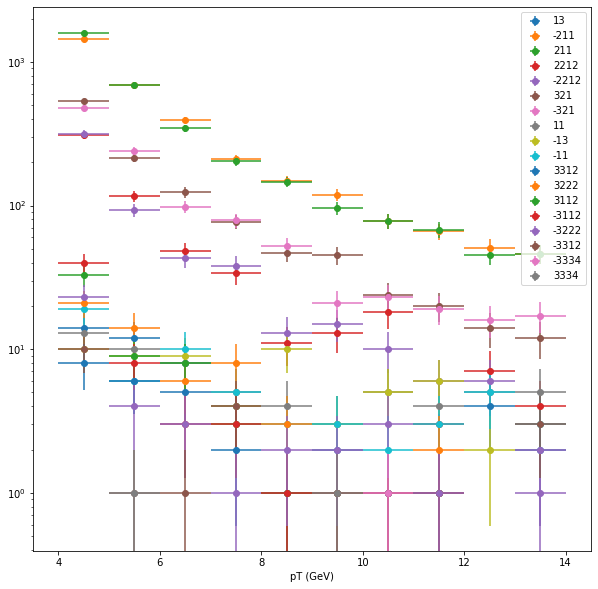

In [117]:
# Plot all_poi_df.pt histogram by pdgId
plt.figure(figsize=(10, 10))
for pdgId in all_poi_df.pdgId.unique():
    pdg_poi_df = all_poi_df[all_poi_df.pdgId == pdgId]
    pdf_hist = np.histogram(pdg_poi_df.pt, bins=np.arange(4, 15, 1))[0]
    # Add poisson error bars
    pdf_hist_err = np.sqrt(pdf_hist)
    plt.errorbar(
        np.arange(4.5, 14.5, 1),
        pdf_hist,
        yerr=pdf_hist_err,
        xerr=0.5,
        fmt="o",
        label=pdgId
    )        
plt.yscale("log")
plt.xlabel("pT (GeV)")
plt.legend()
    

In [123]:
pdfDict = {"electron": 11, "positron": -11, "muon": 13, "antimuon": -13, "pion": 211, "antipion": -211, "kaon": 321, "antikaon": -321, "proton": 2212, "antiproton": -2212}

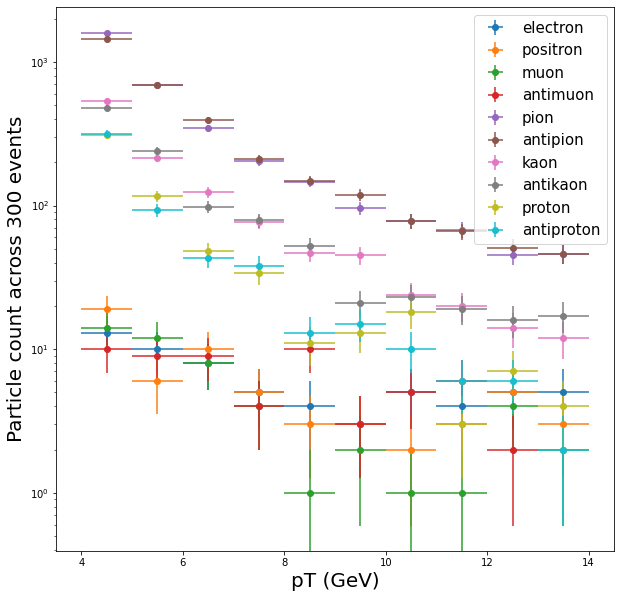

In [136]:
# Plot all_poi_df.pt histogram by pdgId
plt.figure(figsize=(10, 10))
for pdgLabel, pdgId in pdfDict.items():
    pdg_poi_df = all_poi_df[all_poi_df.pdgId == pdgId]
    pdf_hist = np.histogram(pdg_poi_df.pt, bins=np.arange(4, 15, 1))[0]
    # Add poisson error bars
    pdf_hist_err = np.sqrt(pdf_hist)
    plt.errorbar(
        np.arange(4.5, 14.5, 1),
        pdf_hist,
        yerr=pdf_hist_err,
        xerr=0.5,
        fmt="o",
        label=pdgLabel
    )        
plt.yscale("log")
plt.xlabel("pT (GeV)", fontsize=20)
plt.ylabel("Particle count across 300 events", fontsize=20)
plt.legend(fontsize=15)

    

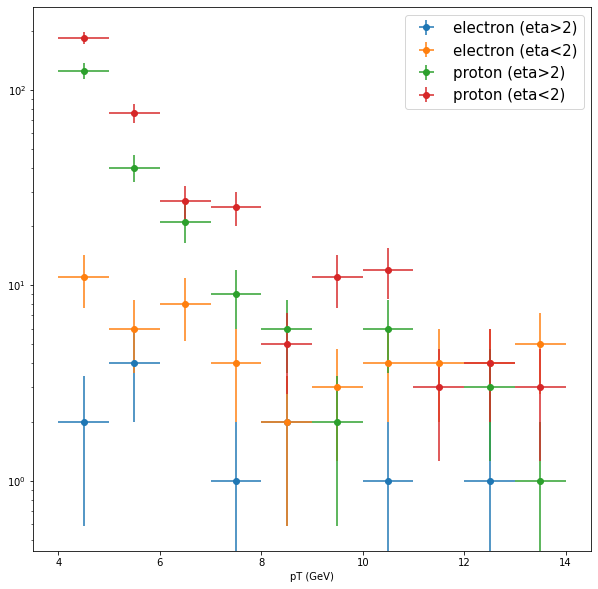

In [127]:
# Plot pdgLabel = electron histogram for high eta and low eta
plt.figure(figsize=(10, 10))
for pdgLabel, pdgId in {"electron": 11, "proton": 2212}.items():
    pdg_poi_df = all_poi_df[all_poi_df.pdgId == pdgId]
    high_eta_pdf_hist = np.histogram(pdg_poi_df[pdg_poi_df.eta.abs() > 2].pt, bins=np.arange(4, 15, 1))[0]
    low_eta_pdf_hist = np.histogram(pdg_poi_df[pdg_poi_df.eta.abs() < 2].pt, bins=np.arange(4, 15, 1))[0]
    # Add poisson error bars
    high_eta_pdf_hist_err = np.sqrt(high_eta_pdf_hist)
    low_eta_pdf_hist_err = np.sqrt(low_eta_pdf_hist)
    plt.errorbar(
        np.arange(4.5, 14.5, 1),
        high_eta_pdf_hist,
        yerr=high_eta_pdf_hist_err,
        xerr=0.5,
        fmt="o",
        label=pdgLabel + " (eta>2)"
    )
    plt.errorbar(
        np.arange(4.5, 14.5, 1),
        low_eta_pdf_hist,
        yerr=low_eta_pdf_hist_err,
        xerr=0.5,
        fmt="o",
        label=pdgLabel + " (eta<2)"
    )
plt.yscale("log")
plt.xlabel("pT (GeV)")
plt.legend(fontsize=15)